## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
print('meow')

meow


In [3]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [19]:
# define the utils

imagenet_mean = np.array([0, 0, 0])
imagenet_std = np.array([1, 1, 1])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, mask_ratio=0.75):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    #x = torch.einsum('nhwc->nchw', x)

    # get embedding shape
    for temp_ratio in [0.8, 0.5, 0]:
        embedding, _, _ = model.forward_encoder(x.float(), mask_ratio=temp_ratio)
        print(f'shape of embedding: {embedding.shape}; masking ratio: {temp_ratio}')

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x).detach().cpu()

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

In [36]:
from torchvision import datasets, transforms
# simple augmentation
transform_test = transforms.Compose([
        # lambda img: transforms.functional.rotate(img, -90),
        # lambda img: transforms.functional.hflip(img),
        # transforms.Grayscale(num_output_channels=3),
        #transforms.RandomResizedCrop((224, 224), scale=(0.8, 1), interpolation=3),  # 3 is bicubic
        #transforms.RandomHorizontalFlip(),
        # transforms.RandomAffine(degrees=(-30, 30), translate=(0.5, 0.5), 
        #                         scale=(0.8, 1.2), shear=(-15, 15), interpolation=3),
        transforms.Resize((224, 224), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,0.1307,0.1307), (0.3081,0.3081,0.3081))
    ])
dataset2 = datasets.CIFAR100('../data', train=True, download=True,
                       transform=transform_test)
test_kwargs = {'batch_size': 1}
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

Files already downloaded and verified


0
torch.Size([1, 3, 224, 224])
1
torch.Size([1, 3, 224, 224])
2
torch.Size([1, 3, 224, 224])


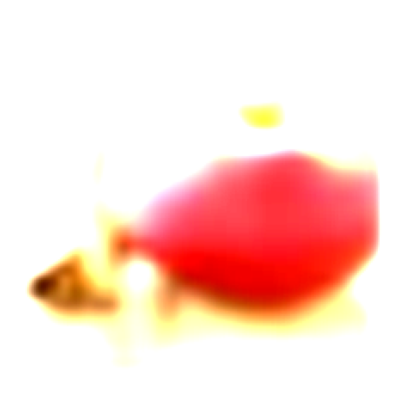

In [31]:
for idx, img_tuple in enumerate(test_loader):
    print(idx)
    plt.rcParams['figure.figsize'] = [5, 5]
    img, label = img_tuple
    print(img.shape)
    assert img.shape == (1, 3, 224, 224)
    img = img.squeeze()
    show_image(torch.einsum('chw->hwc', img))
    if idx == 2:
        break

### Load a pre-trained MAE model

In [9]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth

chkpt_dir = 'mae_visualize_vit_base.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')


--2024-03-12 11:34:20--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.34.53, 13.226.34.122, 13.226.34.83, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.34.53|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 447725789 (427M) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_base.pth’

mae_visualize_vit_b 100%[===================>] 426.98M  32.3MB/s    in 13s     

2024-03-12 11:34:34 (31.7 MB/s) - ‘mae_visualize_vit_base.pth’ saved [447725789/447725789]

<All keys matched successfully>
Model loaded.


### Run MAE on the image

0
MAE with pixel reconstruction:
shape of embedding: torch.Size([1, 40, 768]); masking ratio: 0.8
shape of embedding: torch.Size([1, 99, 768]); masking ratio: 0.5
shape of embedding: torch.Size([1, 197, 768]); masking ratio: 0


/tmp/ipykernel_692113/1595823483.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


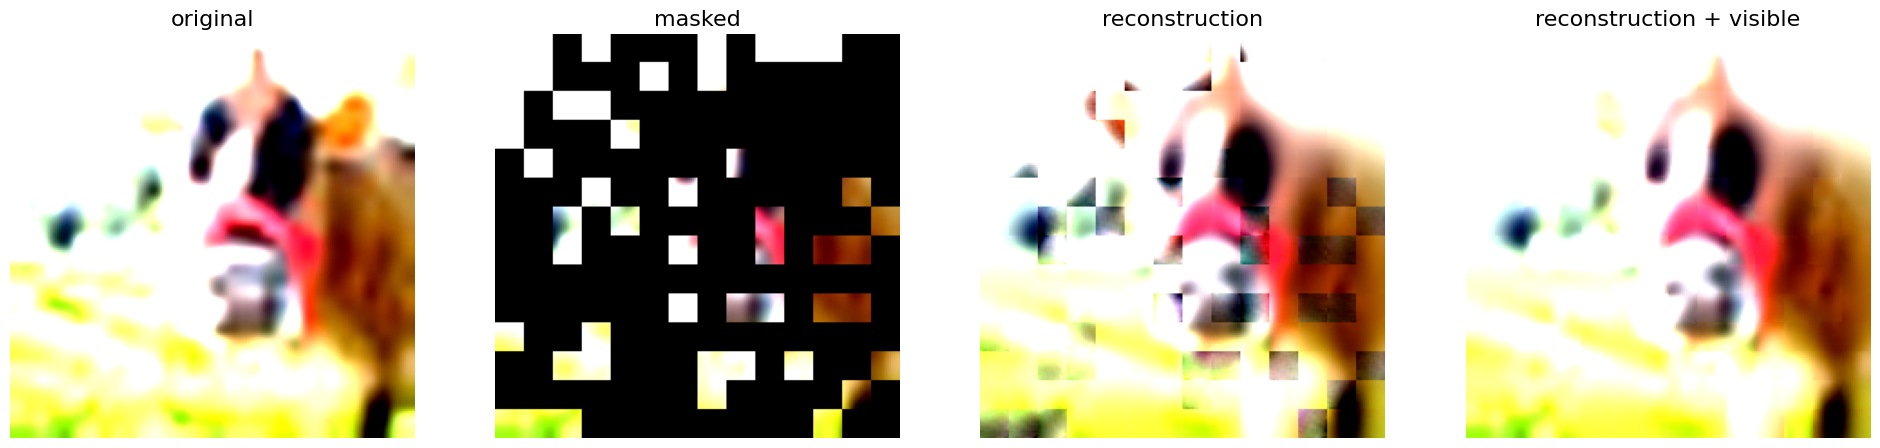

1
MAE with pixel reconstruction:
shape of embedding: torch.Size([1, 40, 768]); masking ratio: 0.8
shape of embedding: torch.Size([1, 99, 768]); masking ratio: 0.5
shape of embedding: torch.Size([1, 197, 768]); masking ratio: 0


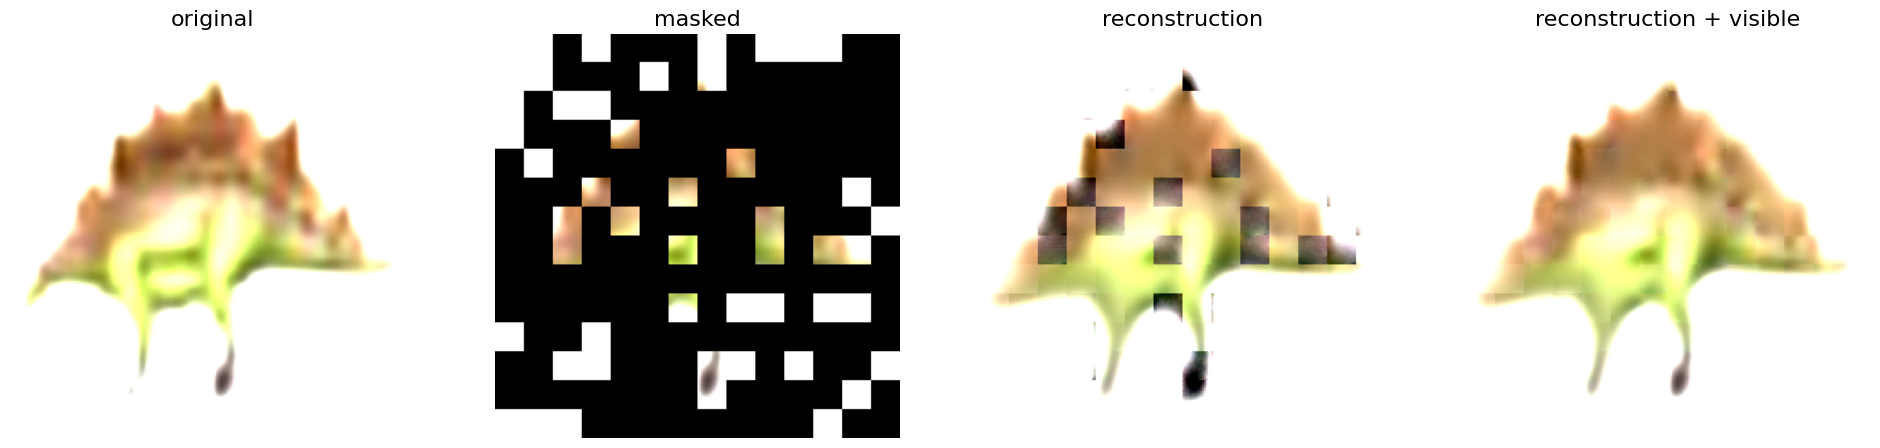

2
MAE with pixel reconstruction:
shape of embedding: torch.Size([1, 40, 768]); masking ratio: 0.8
shape of embedding: torch.Size([1, 99, 768]); masking ratio: 0.5
shape of embedding: torch.Size([1, 197, 768]); masking ratio: 0


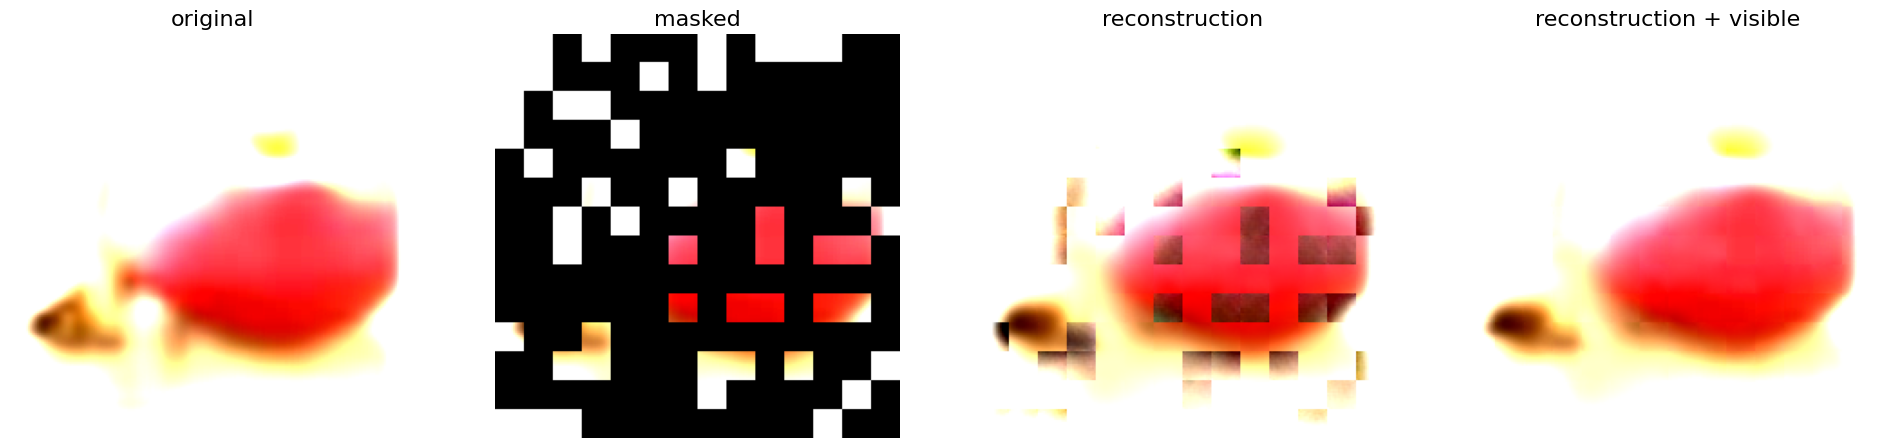

3
MAE with pixel reconstruction:
shape of embedding: torch.Size([1, 40, 768]); masking ratio: 0.8
shape of embedding: torch.Size([1, 99, 768]); masking ratio: 0.5
shape of embedding: torch.Size([1, 197, 768]); masking ratio: 0


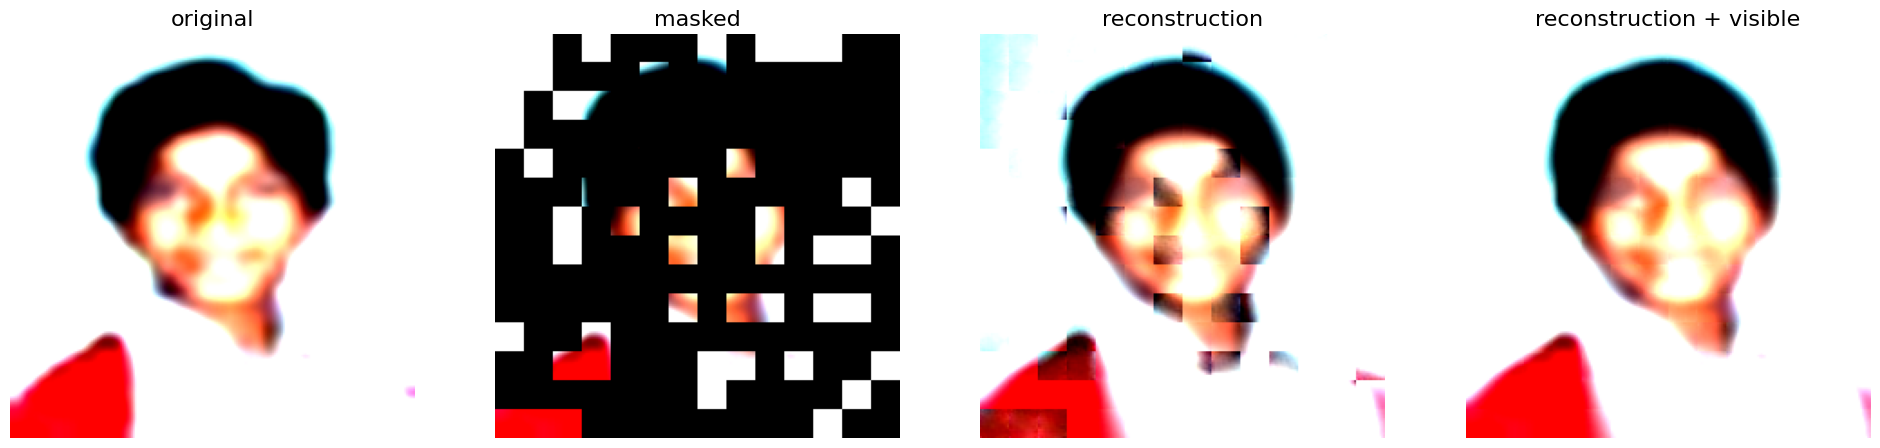

4
MAE with pixel reconstruction:
shape of embedding: torch.Size([1, 40, 768]); masking ratio: 0.8
shape of embedding: torch.Size([1, 99, 768]); masking ratio: 0.5
shape of embedding: torch.Size([1, 197, 768]); masking ratio: 0


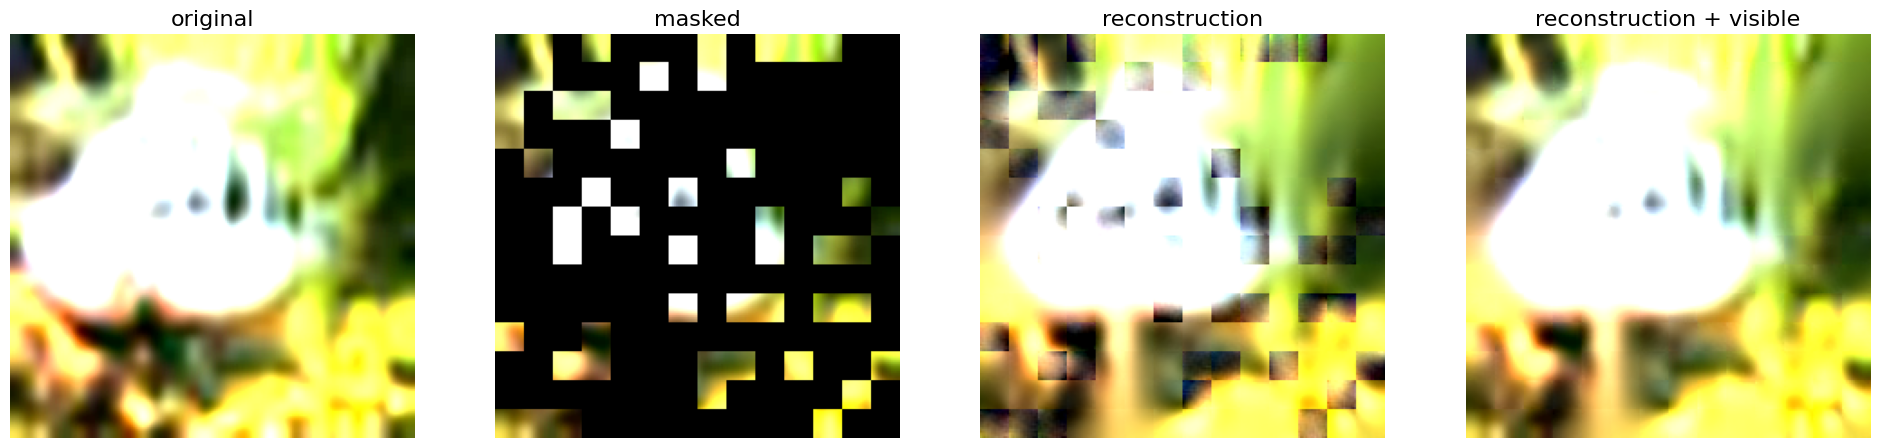

5
MAE with pixel reconstruction:
shape of embedding: torch.Size([1, 40, 768]); masking ratio: 0.8
shape of embedding: torch.Size([1, 99, 768]); masking ratio: 0.5
shape of embedding: torch.Size([1, 197, 768]); masking ratio: 0


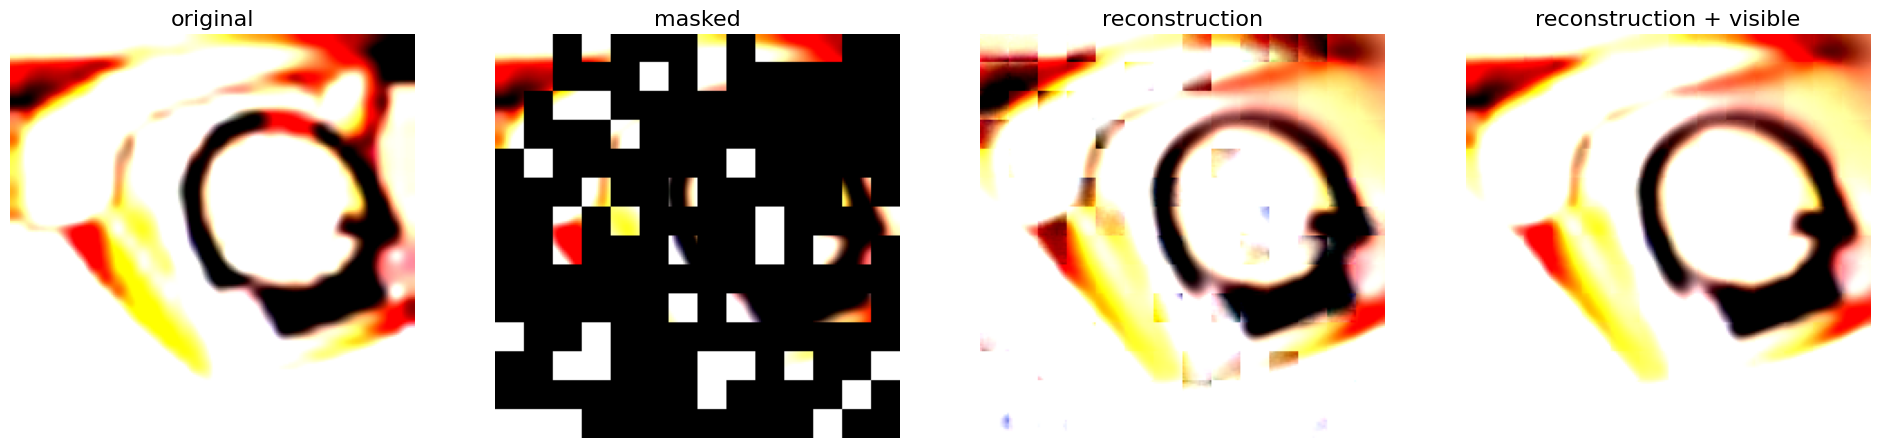

6
MAE with pixel reconstruction:
shape of embedding: torch.Size([1, 40, 768]); masking ratio: 0.8
shape of embedding: torch.Size([1, 99, 768]); masking ratio: 0.5
shape of embedding: torch.Size([1, 197, 768]); masking ratio: 0


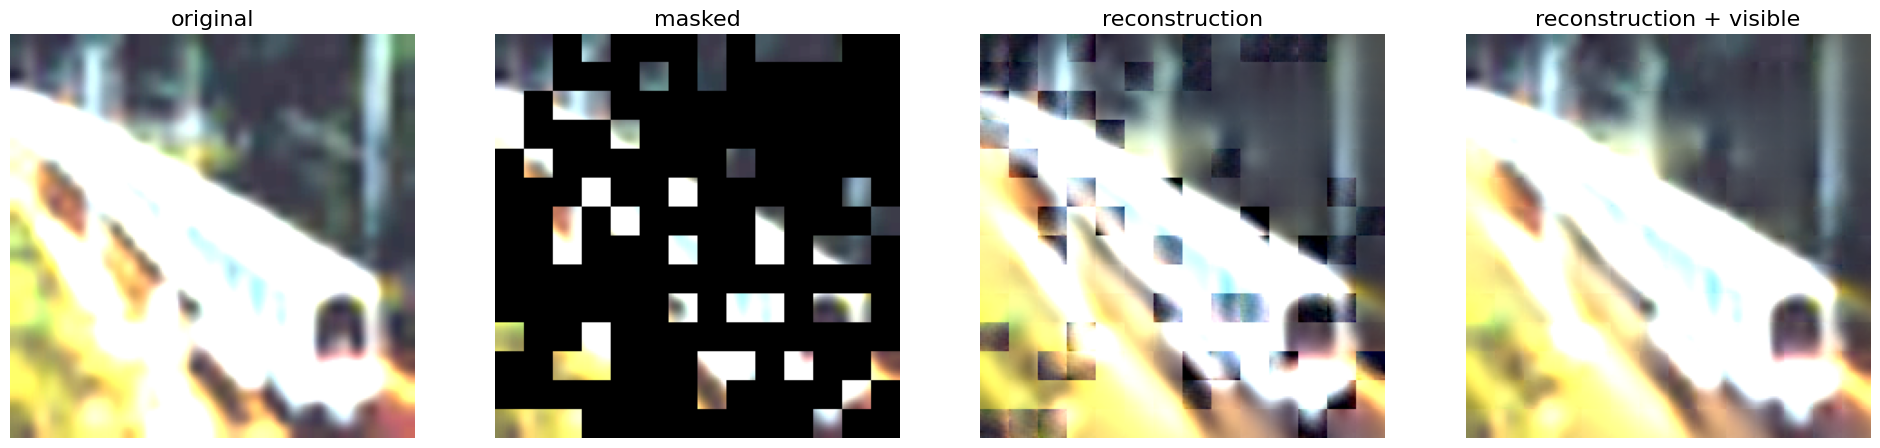

7
MAE with pixel reconstruction:
shape of embedding: torch.Size([1, 40, 768]); masking ratio: 0.8
shape of embedding: torch.Size([1, 99, 768]); masking ratio: 0.5
shape of embedding: torch.Size([1, 197, 768]); masking ratio: 0


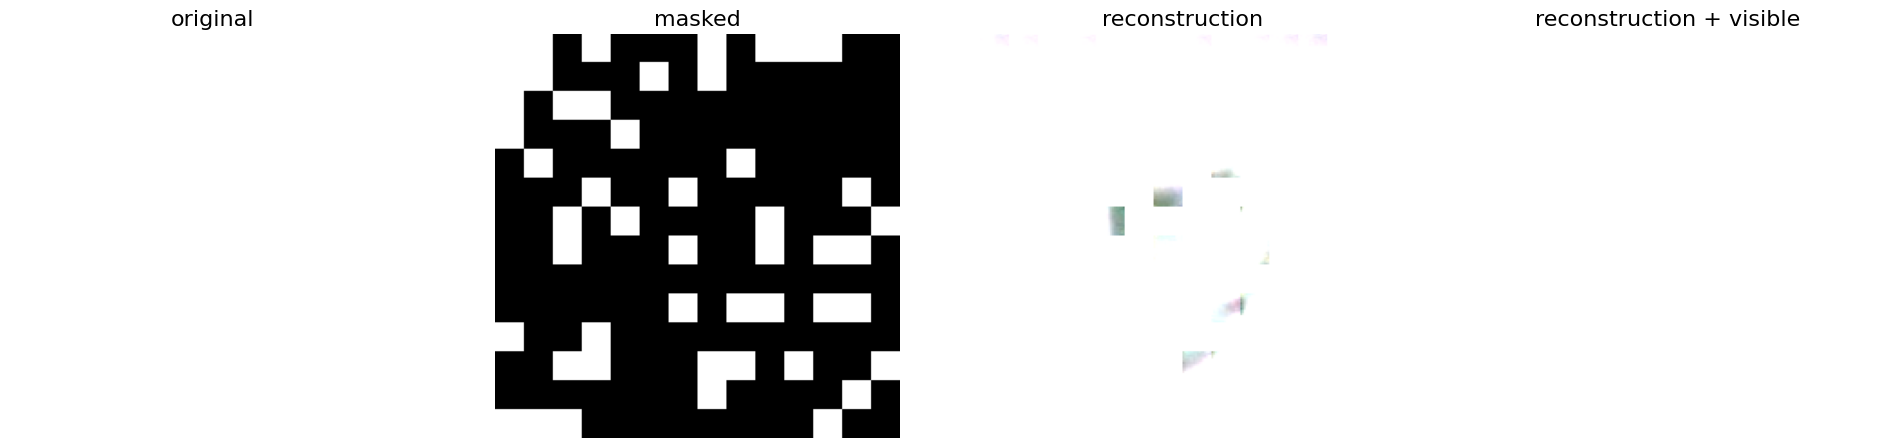

8
MAE with pixel reconstruction:
shape of embedding: torch.Size([1, 40, 768]); masking ratio: 0.8
shape of embedding: torch.Size([1, 99, 768]); masking ratio: 0.5
shape of embedding: torch.Size([1, 197, 768]); masking ratio: 0


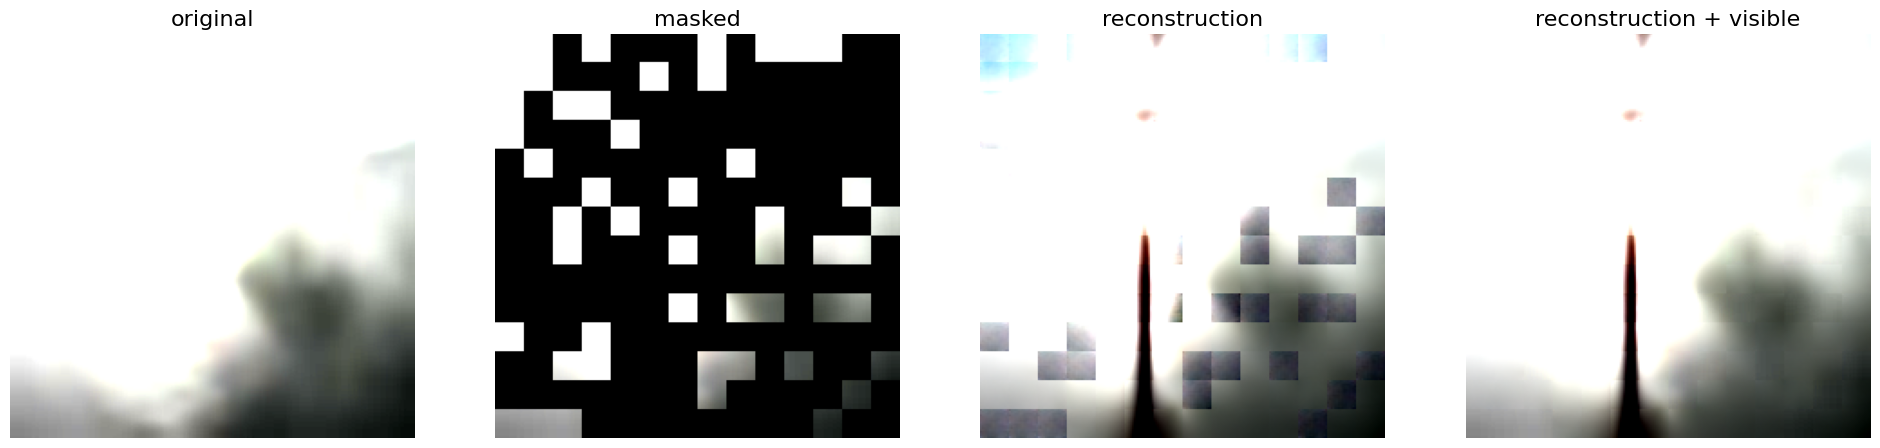

In [32]:
model_mae = model_mae.cuda()
for idx, img_tuple in enumerate(test_loader):
    print(idx)
    plt.rcParams['figure.figsize'] = [5, 5]
    img, label = img_tuple
    assert img.shape == (1, 3, 224, 224)
    img = img.cuda()
    img = img.squeeze()
    #show_image(torch.einsum('chw->hwc', img))

    torch.manual_seed(2)
    print('MAE with pixel reconstruction:')
    run_one_image(img, model_mae, mask_ratio=0.75)
    
    if idx == 8:
        break